<a href="https://colab.research.google.com/github/herysedra/covid19-mankaiza-clone/blob/andrana/scripts/paper/covmdg_lambda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle


import pymc3 as pm
import theano.tensor as tt
import theano
import datetime
import time
#import pingouin 

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

#from pingouin import corr
import pandas.testing as tm



tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

#tilyvoa.set_index('Daty', inplace=True)

tilyvoafar = tilyvoa.groupby('Faritra')
tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)

tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

In [0]:
def delay_cases(new_I_t, len_new_I_t, len_new_cases_obs , delay, delay_arr):


    delay_mat = make_delay_matrix(n_rows=len_new_I_t, 
                                  n_columns=len_new_cases_obs, initial_delay=delay_arr)
    inferred_cases = interpolate(new_I_t, delay, delay_mat)
    return inferred_cases 

def make_delay_matrix(n_rows, n_columns, initial_delay=0):
    """
    Has in each entry the delay between the input with size n_rows and the output
    with size n_columns
    """
    size = max(n_rows, n_columns)
    mat = np.zeros((size, size))
    for i in range(size):
        diagonal = np.ones(size-i)*(initial_delay + i)
        mat += np.diag(diagonal, i)
    for i in range(1, size):
        diagonal = np.ones(size-i)*(initial_delay - i)
        mat += np.diag(diagonal, -i)
    return mat[:n_rows, :n_columns]
    

def interpolate(array, delay, delay_matrix):
    interp_matrix = tt.maximum(1-tt.abs_(delay_matrix - delay), 0)
    interpolation = tt.dot(array,interp_matrix)
    return interpolation

In [5]:
date_data_begin = datetime.date(2020,5,1)
date_data_end = datetime.date(2020,5,17)
num_days_to_predict = 28


diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.

date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)


cases_obs =  np.array(tilyvoamdg.loc[date_data_begin:date_data_end, 'Voareh tvm'])

"""
Mahasedra: (corrected)
cases_obs : the number of infected cases in tana from the 
date_data_begin (1 march 2020) to the date_begin_sim (14 february 2020).
"""

print('Cases of ({}): {} and '
      'day before that: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))

"""
Mahasedra & Joely: output about the new cases at the begin day of 
the forecasting and at the day before.
"""

num_days = (date_data_end - date_begin_sim).days
# 
date_today = date_data_end + datetime.timedelta(days=1)


Cases of (2020-05-17): 304.0 and day before that: 283.0


In [0]:

# ------------------------------------------------------------------------------ #
# model setup and training
# ------------------------------------------------------------------------------ #
np.random.seed(0)

def SIR_model(λ, μ, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin)
    def next_day(λ, S_t, I_t, _):
        new_I_t = λ/N*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t - μ * I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], 
                               outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all

    """
    Mahasedra:
    SIR_model(): provides all values of S, I and new infected cases given
    by the SIR model with the initial conditions S_begin, I_begin, N.
    To be checked
    """



with pm.Model() as model:
    # true cases at begin of loaded data but we do not know the real number
    I_begin = pm.HalfCauchy('I_begin', beta=100)

    # fraction of people that are newly infected each day
    λ = pm.Lognormal("λ", mu=np.log(0.4), sigma=0.5)

    # fraction of people that recover each day, recovery rate mu
    μ = pm.Lognormal('μ', mu=np.log(1/8), sigma=0.2)

    # delay in days between contracting the disease and being recorded
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.2)

    # prior of the error of observed cases
    σ_obs = pm.HalfCauchy("σ_obs", beta=10)

    N_tanatoa = 4e6

    """
    Mahasedra & Joely: Prior distributions of the simple model's parameters 
    θ={λ, μ, D, σ,I0}
    Mahasedra: I suppose that only part of the population can be really susceptible
    to be infected.
    """

    # -------------------------------------------------------------------------- #
    # training the model with loaded data
    # -------------------------------------------------------------------------- #

    S_begin = N_tanatoa - I_begin
    S_past, I_past, new_I_past = SIR_model(λ=λ * tt.ones(num_days-1), μ=μ, 
                                               S_begin=S_begin, I_begin=I_begin,
                                               N=N_tanatoa)
    new_cases_obs = np.diff(cases_obs)
    new_cases_inferred = delay_cases(new_I_past, len_new_I_t=num_days - 1, 
                                     len_new_cases_obs=len(new_cases_obs), 
                                     delay=delay, delay_arr=diff_data_sim)

    # Approximates Poisson
    # calculate the likelihood of the model:
    # observed cases are distributed following studentT around the model
    pm.StudentT(
        "obs",
        nu=4,
        mu=new_cases_inferred,
        sigma=(new_cases_inferred)**0.5 * σ_obs,
        observed=new_cases_obs)  
    
    S_past = pm.Deterministic('S_past', S_past)
    I_past = pm.Deterministic('I_past', I_past)
    new_I_past = pm.Deterministic('new_I_past', new_I_past)
    new_cases_past = pm.Deterministic('new_cases_past', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # fp1 / prediction, start with no changes in policy
    # red curve: no changes in policy
    # transient = 0 day
    # reduc_factor = 0
    # no change in λ along time
    # -------------------------------------------------------------------------- #

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_no_change = SIR_model(λ=λ*tt.ones(num_days_to_predict), μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, N=N_tanatoa)
    S_no_change, I_no_change, new_I_no_change = forecast_no_change

    #saves the variables for later retrieval
    pm.Deterministic('S_no_change', S_no_change)
    pm.Deterministic('I_no_change', I_no_change)
    pm.Deterministic('new_I_no_change', new_I_no_change)

    """
    PyMC3 allows you to freely do algebra with RVs in all kinds of ways (...).
    While these transformations work seamlessly, their results are not 
    stored automatically. Thus, if you want to keep track of a transformed 
    variable, you have to use pm.Deterministic.
    """

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_no_change]), 
                                     len_new_I_t=diff_data_sim + num_days_to_predict, 
                                     len_new_cases_obs=num_days_to_predict, 
                                     delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_no_change', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # fp2 / social distancing, m reduced by about 50 percent, 
    # orange curve: mild social distancing
    # transient = 7 days
    # reduc_factor = 0.5 (mild)
    # change in λ along time
    # days_offset = 0  i.e. start the decrease in spreading rate after this
    # -------------------------------------------------------------------------- #
    
    #For all following predictions:
    length_transient = 7  # days


    # λ is decreased by 50%
    reduc_factor_mild = 0.5
    days_offset = 0  # start the decrease in spreading rate after this

    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_soc_dist= λ * (1 - λ_correction * reduc_factor_mild) 

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_soc_dist = SIR_model(λ=λ_t_soc_dist, μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, 
                        N=N_tanatoa)
    S_soc_dist, I_soc_dist, new_I_soc_dist = forecast_soc_dist
    pm.Deterministic('S_soc_dist', S_soc_dist)
    pm.Deterministic('I_soc_dist', I_soc_dist)
    pm.Deterministic('new_I_soc_dist', new_I_soc_dist)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_soc_dist]), 
                                    len_new_I_t=diff_data_sim + num_days_to_predict, 
                                    len_new_cases_obs=num_days_to_predict, 
                                    delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_soc_dist', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # fp3 / isolation, almost no new infections besides baseline after transient phase
    # green curve : strong social distancing starting at day 0
    # transient = 7 days
    # reduc_factor = 0.9 (strong)
    # change in λ along time
    # days_offset = 0  
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 0  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol= λ * (1 - λ_correction * reduc_factor_strong)

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_isol = SIR_model(λ=λ_t_isol , μ=μ, 
                              S_begin=S_begin, I_begin=I_begin, 
                              N=N_tanatoa)
    S_isol, I_isol, new_I_isol = forecast_isol

    pm.Deterministic('S_isol', S_isol)
    pm.Deterministic('I_isol', I_isol)  
    pm.Deterministic('new_I_isol', new_I_isol)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol]), 
                                len_new_I_t=diff_data_sim + num_days_to_predict, 
                                len_new_cases_obs=num_days_to_predict, 
                                delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_isol', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # fp4 / isolation 5 days later, almost no new infections besides baseline after transient phase
    # fuchsia curve
    # transient = 7 days
    # reduc_factor = 0.9 (strong)
    # change in λ along time
    # days_offset = 5  
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol_later= λ * (1 - λ_correction * reduc_factor_strong) 

    S_begin = S_past[-1]
    I_S_beginbegin = I_past[-1]
    forecast_isol_later = SIR_model(λ=λ_t_isol_later, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_tanatoa)
    S_isol_later, I_isol_later, new_I_isol_later = forecast_isol_later

    pm.Deterministic('S_isol_later', S_isol_later)
    pm.Deterministic('I_isol_later', I_isol_later)  
    pm.Deterministic('new_I_isol_later', new_I_isol_later)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol_later]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_isol_later', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # fp5 / isolation 5 days earlier, almost no new infections besides baseline after transient phase
    # gray curve
    # transient = 7 days
    # reduc_factor = 0.9 (strong)
    # change in λ along time
    # days_offset = -5 (earlier)  
    # -------------------------------------------------------------------------- #

    length_transient = 7

    # λ is decreased by 90%
    reduc_factor = 0.9
    days_offset = -5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(days_offset, num_days_to_predict)

    # change in λ along time

    λ_t_earlier  = tt.clip((time_arr-days_offset) / length_transient, 0, 1)*\
                      (λ*(1-reduc_factor) - λ) + λ


    S_begin = S_past[-1 + days_offset]
    I_begin = I_past[-1 + days_offset]
    forecast_earlier = SIR_model(λ=λ_t_earlier, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_tanatoa)
    S_earlier, I_earlier, new_I_earlier = forecast_earlier

    pm.Deterministic('S_earlier', S_earlier)
    pm.Deterministic('I_earlier', I_earlier)  
    pm.Deterministic('new_I_earlier', new_I_earlier)
    pm.Deterministic('λ_t_earlier', λ_t_earlier)


    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:days_offset], new_I_earlier]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    
    pm.Deterministic('new_cases_earlier', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # fp6 / long transient scenario  (cyan curve)
    # transient = 14 days (long)
    # reduc_factor = 0.9 (strong)
    # change in λ along time
    # days_offset = -3.5
    # days_offset_sim = -4 
    # -------------------------------------------------------------------------- #

    length_transient = 14

    # λ is decreased by 90%
    reduc_factor = 0.9
    days_offset = -3.5  # start the decrease in spreading rate after this
    days_offset_sim = -4

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(days_offset_sim, num_days_to_predict)

    # change in λ along time

    λ_t_long_trans  = tt.clip((time_arr-days_offset) / length_transient, 0, 1)*\
                      (λ*(1-reduc_factor) - λ) + λ


    S_begin = S_past[-1 + days_offset_sim]
    I_begin = I_past[-1 + days_offset_sim]
    forecast_long_trans = SIR_model(λ=λ_t_long_trans, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_tanatoa)
    S_long_trans, I_long_trans, new_I_long_trans = forecast_long_trans

    pm.Deterministic('S_long_trans', S_long_trans)
    pm.Deterministic('I_long_trans', I_long_trans)  
    pm.Deterministic('new_I_long_trans', new_I_long_trans)
    pm.Deterministic('λ_t_long_trans', λ_t_long_trans)

    


    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:days_offset_sim], new_I_long_trans]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_long_trans', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # fp7 / immediate transient scenario (Brown curve)
    # transient = 0.5 days
    # reduc_factor = 0.9 (strong)
    # change in λ along time
    # days_offset = 3.5  
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 3.5 # start the decrease in spreading rate after this
    length_transient = 0.5

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol= λ * (1 - λ_correction * reduc_factor_strong)

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_isol = SIR_model(λ=λ_t_isol , μ=μ, 
                              S_begin=S_begin, I_begin=I_begin, 
                              N=N_tanatoa)
    S_isol, I_isol, new_I_isol = forecast_isol

    pm.Deterministic('S_immedi', S_isol)
    pm.Deterministic('I_immedi', I_isol)  
    pm.Deterministic('new_immedi', new_I_isol)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol]), 
                                len_new_I_t=diff_data_sim + num_days_to_predict, 
                                len_new_cases_obs=num_days_to_predict, 
                                delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_immedi', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # run model, pm trains and predicts when calling this
    # -------------------------------------------------------------------------- #
    
    time_beg = time.time()
    trace = pm.sample(draws=3000, tune=800, chains=2)
    print("Model run in {:.2f} s".format(time.time() - time_beg))

  #The number of effective samples is smaller than 25% for some parameters.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ_obs, delay, μ, λ, I_begin]
100%|██████████| 3800/3800 [02:02<00:00, 31.14it/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


Model run in 242.69 s


effective m: 1.142 +- 0.056
λ: 0.269 [0.164, 0.398]


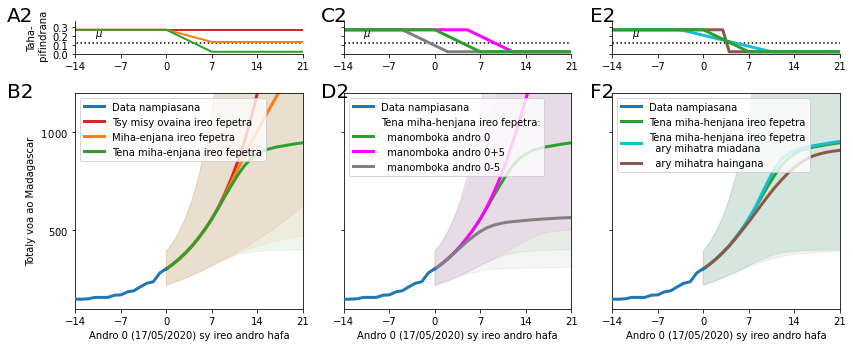

In [0]:
legends_lang = {
    "english": [
        # bottom left
        "Data nampiasana",
        [
            "Tsy misy ovaina ireo fepetra",
            "Miha-enjana ireo fepetra",
            "Tena miha-enjana ireo fepetra",
            "Tena miha-henjana 5 andro lasa (10/03/20)",
        ],
        "Andro 0 (17/05/2020) sy ireo andro hafa",
        "Totaly voa ao Madagascar",
        "Fanombohan'ireo fepetra",
        # bottom right
        'Data nampiasana',['Tena miha-henjana ireo fepetra:',
                           '  manomboka andro 0', 
                           '  manomboka andro 0+5',
                           "  manomboka andro 0-5"],
        'Andro 0 (17/05/2020) sy ireo andro hafa',
        'Totaly voa ao Madagascar',
        "Fanombohan'ireo fepetra",
        "Taha-\n pifindrana",
        ['Tena miha-henjana ireo fepetra',
         'Tena miha-henjana ireo fepetra\n  ary mihatra miadana ', 
         '  ary mihatra haingana'],
    ],
}

#Legends

obs_cases_labels = ['new_cases_no_change', 'new_cases_soc_dist', 
                    'new_cases_isol', 'new_cases_isol_later','new_cases_earlier', 
                    'new_cases_long_trans','new_cases_immedi']

# label the variables related to the new_cases_inferred

cases_obs_to_plot = cases_obs
cases_obs_to_plot_future = cases_obs


def return_obs_cases_future(trace):
  obs_cases_future = dict()
  for label in obs_cases_labels:
    obs_cases_future[label] = np.cumsum(trace[label], axis=1) + \
        np.sum(trace.new_cases_past, axis=1)[:, None] + cases_obs[0]
    obs_cases_future[label] = obs_cases_future[label].T
  return obs_cases_future

obs_cases_labels_local = obs_cases_labels[:]
obs_cases_labels_local.pop(3)

for lang, legends_list in legends_lang.items():
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[12, 6],gridspec_kw={'width_ratios': [1, 1,1]})

    # bottom left (Fig. B2)
    colors = ["tab:red", "tab:orange", "tab:green"]
    dict_obsc_cases = return_obs_cases_future(trace)
    ax = axes[1, 0]

    # Below is about the confirmed cases

    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, label=legends_list[0], linewidth=3, color='tab:blue', 
                zorder=5)

    # above is about the confirmed cases

    time = np.arange(0, len(cases_obs_to_plot_future))
    #ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
    #        zorder=5)


    for label, color, legend in zip(obs_cases_labels_local, colors, legends_list[1]):
        time = np.arange(0, num_days_to_predict)
        cases = dict_obsc_cases[label]
        # cases = np.concatenate([np.ones((1,cases.shape[1]))*cases_obs[-1], cases], axis=0)

        median = np.median(cases, axis=-1)
        percentiles = (
            np.percentile(cases, q=2.5, axis=-1),
            np.percentile(cases, q=97.5, axis=-1),
        )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(-14, 21)
    ax.set_ylim(100, 1200)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[2])
    ax.set_ylabel(legends_list[3])
    # ax.locator_params(axis='y', nbins=4)
    ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    ax.locator_params(nbins=4, axis="y")
    func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.text(-0.3, 0.98, "B2", transform=ax.transAxes, size=20)

    
    """
    ax.annotate(
        legends_list[4],
        xy=(0.0, 100), #
        xycoords="data",
        xytext=(0.35, 0.4),
        textcoords="axes fraction",
        size=10,
        va="center",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc="black"
        ),
    )
    """
    # Above is Fig. B2

    # bottom middle (Fig. D2)
    ax = axes[1, 1]
    colors = ["tab:green", "fuchsia", 'gray']
    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, label=legends_list[5], linewidth=3, color='tab:blue', 
                zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    #ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
    #        zorder=5)
    time = np.arange(-len(cases_obs) + 1, 1)

    dict_obsc_cases = return_obs_cases_future(trace)
    ax.plot([], [], alpha=0, label=legends_list[6][0])
    for label, color, legend in zip(obs_cases_labels[2:], colors, legends_list[6][1:]):
        time = np.arange(num_days_to_predict)
        cases = dict_obsc_cases[label]
        #cases = np.concatenate([np.ones((1, cases.shape[1])) * cases_obs[-1], cases], axis=0)
        median = np.median(cases, axis=-1)
        percentiles = (
            np.percentile(cases, q=2.5, axis=-1),
            np.percentile(cases, q=97.5, axis=-1),
        )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(-14, 21)
    ax.set_ylim(100, 1200)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[7])
    #ax.set_ylabel(legends_list[8])
    ax.locator_params(axis="y", nbins=4)
    ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    #func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    #ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.tick_params(labelleft=False)    

    ax.text(-0.1, 0.98, "D2", transform=ax.transAxes, size=20)
    """
    ax.annotate(
        legends_list[9],
        xy=(0.0, 100),
        xycoords="data",
        xytext=(0.35, 0.4),
        textcoords="axes fraction",
        size=10,
        va="center",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.15", fc=colors[0]
        ),
    )
    ax.annotate(
        "",
        xy=(5.0, 120),
        xycoords="data",
        xytext=(0.4, 0.35),
        textcoords="axes fraction",
        size=10,
        va="center",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc=colors[1]
        ),
    )

    ax.annotate(
        "",
        xy=(-5.0, 100),
        xycoords="data",
        xytext=(0.32, 0.35),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc=colors[2]
        ),
    )
    """

    # Above is Fig. D2

    # bottom right (Fig. F2)
    ax = axes[1, 2]
    colors = ["tab:green", "tab:cyan", 'tab:brown']
    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, label=legends_list[5], linewidth=3, color='tab:blue', 
                zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    #ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
    #        zorder=5)
    time = np.arange(-len(cases_obs) + 1, 1)

    dict_obsc_cases = return_obs_cases_future(trace)
    for label, color, legend in zip([obs_cases_labels[2], obs_cases_labels[-1], obs_cases_labels[-2]], 
                                    colors, legends_list[11]):
        time = np.arange(num_days_to_predict)
        cases = dict_obsc_cases[label]
        #cases = np.concatenate([np.ones((1, cases.shape[1])) * cases_obs[-1], cases], axis=0)
        median = np.median(cases, axis=-1)
        percentiles = (
            np.percentile(cases, q=2.5, axis=-1),
            np.percentile(cases, q=97.5, axis=-1),
        )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(-14, 21)
    ax.set_ylim(100, 1200)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[7])
    #ax.set_ylabel(legends_list[8])
    ax.locator_params(axis="y", nbins=4)
    ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    #func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    #ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.tick_params(labelleft=False)    

    ax.text(-0.1, 0.98, "F2", transform=ax.transAxes, size=20)

    # Above is Fig.F2

    # top left (Fig. A2)
    ax = axes[0, 0]

    m = np.median(trace.λ)
    decrease_in = 7  # days
    time = np.arange(-14, 22)
    m_correction = np.clip(time / decrease_in, 0, 1)
    reduction_fact_strong = 0.9
    reduction_fact_mild = 0.5

    ax.plot(time, np.ones_like(time)*m, linewidth=2, color="tab:red")
    ax.plot(
        time,
        (1 - m_correction * reduction_fact_mild)*m,
        linewidth=2,
        color="tab:orange" )
    ax.plot(
        time,
        (1 - m_correction * reduction_fact_strong)*m,
        linewidth=2,
        color="tab:green" )
    ax.hlines(np.median(trace.μ),-50,50, linestyles=':',label='critical point')
    #ax.legend()

    ax.set_ylabel(legends_list[10])
    # ax.set_xlabel("days from now")
    # ax.legend(loc='lower left')
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    ax.set_ylim(0, 0.37)
    ax.set_yticks([0, 0.1, 0.2, 0.3])
    ax.set_xlim(-14, 21)
    ax.set_aspect(14, adjustable="box")
    ax.text(-0.3, 0.98, "A2", transform=ax.transAxes, size=20)
    ax.text(-11, 0.2, "$\mu$", transform=ax.transData, size=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Above is Fig. A2

    # top middle (Fig. C2)
    ax = axes[0, 1]

    m = np.median(trace.λ)
    length_transient = 7  # days
    time = np.arange(-14, 22)
    
    reduc_factor_mild = 0.9
    days_offset_mild = -5  # start the decrease in spreading rate after this
    reduc_factor_strong = 0.9
    days_offset_strong = 5

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_t1  = np.clip((time-days_offset_mild) / length_transient, 0, 1)*\
                      (m*(1-reduc_factor_mild) - m)+m
    λ_t2  = np.clip((time-days_offset_strong) / length_transient, 0, 1)*\
                      (m*(1-reduc_factor_strong) - m)+m

    #ax.plot(time, np.ones_like(time), linewidth=3, color="tab:red", label="no change")
    
    ax.plot(
        time,
        (λ_t2),
        linewidth=3,
        color="fuchsia",
    )
    ax.plot(
        time,
        (λ_t1),
        linewidth=3,
        color="gray",
    )
    ax.plot(
        time,
        (1 - m_correction * reduction_fact_strong)*m,
        linewidth=3,
        color="tab:green",
    )
    ax.hlines(np.median(trace.μ),-50,50, linestyles=':',label='critical point')
    #ax.legend()

    #ax.set_ylabel(legends_list[10])
    # ax.set_xlabel("days from now")
    # ax.legend(loc='lower left')
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    #ax.set_yticks([0, 0.5, 1.0])
    ax.set_yticks([0, 0.1, 0.2, 0.3])
    ax.tick_params(labelleft=False)    
    ax.set_ylim(0, 0.37)
    ax.set_xlim(-14, 21)
    ax.set_aspect(14, adjustable="box")
    ax.text(-0.1, 0.98, "C2", transform=ax.transAxes, size=20)
    ax.text(-11, 0.2, "$\mu$", transform=ax.transData, size=10)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Above is Fig. C2

    # top right (Fig. E2)
    ax = axes[0, 2]

    m = np.median(trace.λ)
    length_transient1 = 14  # days
    length_transient2 = 0.5
    time = np.arange(-14, 22)
    reduc_factor_mild = 0.9
    days_offset_mild = -3.5  # start the decrease in spreading rate after this

    reduc_factor_strong = 0.9
    days_offset_strong = 3.5

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_t1  = np.clip((time-days_offset_mild) / length_transient1, 0, 1)*\
                      (m*(1-reduc_factor_mild) - m)+m
    λ_t2  = np.clip((time-days_offset_strong) / length_transient2, 0, 1)*\
                      (m*(1-reduc_factor_strong) - m)+m

    #ax.plot(time, np.ones_like(time), linewidth=3, color="tab:red", label="no change")
    
    ax.plot(
        time,
        λ_t2,
        linewidth=3,
        color="tab:brown",
    )
    ax.plot(
        time,
        (λ_t1),
        linewidth=3,
        color="tab:cyan",
    )
    ax.plot(
        time,
        (1 - m_correction * reduction_fact_strong)*m,
        linewidth=3,
        color="tab:green",
    )

    ax.hlines(np.median(trace.μ),-50,50, linestyles=':',label='critical point')
    #ax.legend()

    #ax.set_ylabel(legends_list[10])
    # ax.set_xlabel("days from now")
    # ax.legend(loc='lower left')
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    ax.set_yticks([0, 0.1, 0.2, 0.3])
    ax.tick_params(labelleft=False)    
    ax.set_ylim(0, 0.37)
    ax.set_xlim(-14, 21)
    ax.set_aspect(14, adjustable="box")
    ax.text(-0.1, 0.98, "E2", transform=ax.transAxes, size=20)
    ax.text(-11, 0.2, "$\mu$", transform=ax.transData, size=10)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Above is Fig. E2.


    # wrapping up
    fig.subplots_adjust(hspace=-0.50)
    fig.subplots_adjust(wspace=-.1)
    fig.tight_layout()
    fig.savefig(
        path_to_save + "lambdatanatoa.png".format(lang), dpi=300
    )
    #fig.savefig(path_to_save + "lambdatanatoa.pdf")

print('effective m: {:.3f} +- {:.3f}'.format(1+np.median(trace.λ - trace.μ), np.std(trace.λ - trace.μ)))
print('λ: {:.3f} [{:.3f}, {:.3f}]'.format(np.median(trace.λ), *np.percentile(trace.λ, q=(2.5, 97.5))))

114.20696780225678
(25, 25)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:255: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


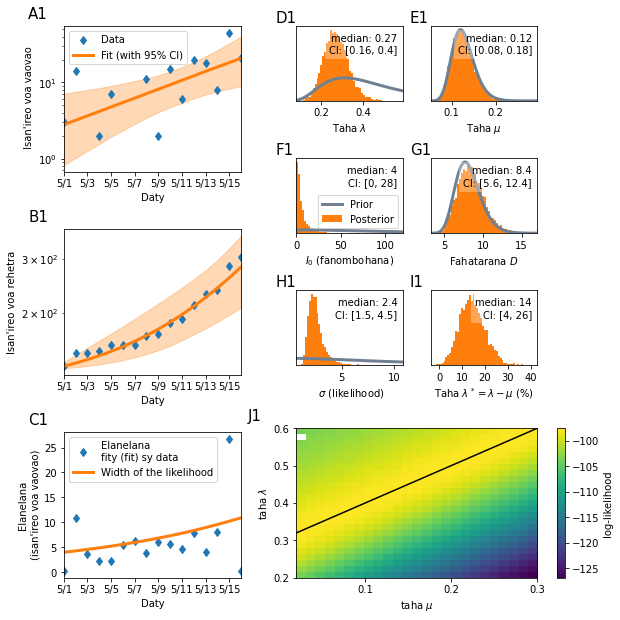

In [0]:
def truncate_number(number, precision):
    number = round(number, ndigits = precision)
    #number = round(number - number%(10**(-precision)),10)
    if precision == 0:
        number = int(round(number))
    return str(number)

def print_median_CI(arr, prec = 2):
    f_trunc = lambda n: truncate_number(n, prec)
    med = f_trunc(np.median(arr))
    perc1, perc2 = f_trunc(np.percentile(arr, q=2.5)), f_trunc(np.percentile(arr, q=97.5))
    #print('The 95% CI of {} is [{:.3f} , {:.3f}] with a median of {:.3f}'.format(label, med, perc1, perc2))
    return 'median: {}\nCI: [{}, {}]'.format(med, perc1, perc2)

def conv_time_to_mpl_dates(arr):
    return matplotlib.dates.date2num([datetime.timedelta(days=float(date)) + date_data_end for date in arr])

#Definitions
letter_size = 15
ci_location = [0.95,0.9]
alpha_texbox = 0.3
font_text = 10

#Making all square for simplicity
len1 = 5
len2 = 3

fig = plt.figure(figsize=(8.5,8.5),constrained_layout=True)
gs = fig.add_gridspec(15,11)

ax_cases_new = fig.add_subplot(gs[0:len1,0:len1])
ax_cases_total = fig.add_subplot(gs[len1:2*len1,0:len1])
ax_error = fig.add_subplot(gs[2*len1:3*len1,0:len1])

ax_param_infection  = fig.add_subplot(gs[0:len2,len1:len1+len2])
ax_param_recovery = fig.add_subplot(gs[0:len2,len1+len2:len1+2*len2])

ax_param_izero = fig.add_subplot(gs[len2:2*len2,len1:len1+len2])
ax_param_delay = fig.add_subplot(gs[len2:2*len2,len1+len2:len1+2*len2])

ax_param_width = fig.add_subplot(gs[2*len2:3*len2,len1:len1+len2])
ax_param_effective_rate = fig.add_subplot(gs[2*len2:3*len2,len1+len2:len1+2*len2])

ax_likelihood = fig.add_subplot(gs[3*len2:3*len1,len1:len1+2*len2])

#manomboka eto Sar. A1

#Plots things
pos_letter = (-0.2, 1.05)

ax = ax_cases_new
time = np.arange(-len(cases_obs)+1, 0)
mpl_dates = conv_time_to_mpl_dates(time) 
start_date, end_date = mpl_dates[0], mpl_dates[-1]
ax.plot(mpl_dates, np.diff(cases_obs), 'd', markersize=6, label='Data')
percentiles = np.percentile(trace.new_cases_past, q=2.5, axis=0), np.percentile(trace.new_cases_past, q=97.5, axis=0)
ax.plot(mpl_dates, np.median(trace.new_cases_past, axis=0),color='tab:orange', label='Fit (with 95% CI)', lw=3)
ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
ax.set_yscale('log')
ax.set_ylabel(" Isan'ireo voa vaovao")
ax.set_xlabel('Daty')
ax.legend()
ax.text(pos_letter[0], pos_letter[1], "A1", transform=ax.transAxes, size=letter_size)
#mifarana eto Sar. A1

#manomboka eto Sar. B1
ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))
ax.set_xlim(start_date, end_date)

ax = ax_cases_total
ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=6, label='Data')
cum_cases = np.cumsum(trace.new_cases_past, axis=1) + cases_obs[0]
percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
ax.plot(mpl_dates, np.median(cum_cases, axis=0),color='tab:orange', label='Fit (with 95% CI)', lw=3)
ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
ax.set_yscale('log')
ax.set_ylabel("Isan'ireo voa rehetra")
ax.set_xlabel('Daty')
#ax.legend()
ax.text(pos_letter[0], pos_letter[1], "B1", transform=ax.transAxes, size=letter_size)
#mifarana eto Sar. B1

#manomboka eto Sar. C1
ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))
ax.set_xlim(start_date, end_date)

ax = ax_error
ax.plot(mpl_dates, np.abs(np.median(trace.new_cases_past, axis=0) - np.diff(cases_obs)), 
        'd', markersize=6,
         label='Elanelana\n'
               'fity (fit) sy data')
ax.plot(mpl_dates, np.sqrt(np.median(trace.new_cases_past, axis=0))*np.median(trace.σ_obs, axis=0),
         label='Width of the likelihood', lw=3)
ax.set_ylabel("Elanelana\n(isan'ireo voa vaovao)")
ax.set_xlabel('Daty')
ax.legend(loc='upper left')
print(np.median(np.sum(trace.new_cases_past[:, :-2], axis=1)+ trace.I_begin))
ax.text(pos_letter[0], pos_letter[1], "C1", transform=ax.transAxes, size=letter_size)
#plt.tight_layout()

#mifarana eto Sar. C1

#manomboka eto Sar. D1
ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))
ax.set_xlim(start_date, end_date)
plt.savefig(path_to_save + 'check_fit_composed.png', dpi=300)
ax = ax_param_infection
ax.hist(trace.λ, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=0.4, s=0.5), label='Prior',
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Taha $\lambda$')
text = print_median_CI(trace.λ, prec=2)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
      verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "D1", transform=ax.transAxes, size=letter_size)
#ax.legend(loc='upper right')

#mifarana eto Sar. D1

# manomboka eto Sar. E1
ax = ax_param_recovery
ax.hist(trace.μ, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=1/8, s=0.2), label='Prior',
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Taha $\mu$')
text = print_median_CI(trace.μ, prec=2)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
      verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "E1", transform=ax.transAxes, size=letter_size)
#ax.legend(loc='upper right')

#mifarana eto Sar. E1

#manomboka eto Sar. G1
ax = ax_param_effective_rate
ax.locator_params(nbins=5)
#bins = np.linspace(-0.11, 0.304, 200)
ax.hist((trace.λ - trace.μ)*100, bins=50, color='tab:orange')
ax.set_xlabel('Taha $\lambda^* = \lambda - \mu$ (%)')#\n'
          #'inferred from data - from {} to {}'.format(date_data_begin.isoformat(), 
          #                                            date_data_end.isoformat()))
ax.set_ylabel('Number of Monte-Carlo samples')
text = print_median_CI((trace.λ - trace.μ)*100, prec=0)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
      verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
ax.text(pos_letter[0], pos_letter[1], "I1", transform=ax.transAxes, size=letter_size)
#mifarana eto Sar. I1

#manomboka eto Sar. G1
ax = ax_param_delay
ax.hist(trace.delay, bins=50, density=True, color='tab:orange',
        label='Posterior')
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.lognorm.pdf(x, scale=8, s=0.2), label='Prior',
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_ylabel('Density')
ax.set_xlabel('Fahatarana $D$')
text = print_median_CI(trace.delay, prec=1)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
      verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
#ax.legend(loc='upper right')
ax.text(pos_letter[0], pos_letter[1], "G1", transform=ax.transAxes, size=letter_size)

#mifarana eto Sar. G1

#manomboka eto Sar. H1
ax = ax_param_width
ax.hist(trace.σ_obs, bins=50, color='tab:orange', density=True, label='Posterior')
ax.set_ylabel('Density')
ax.set_xlabel(" $\sigma$ (likelihood)")
limits = ax.get_xlim()
x = np.linspace(*limits, num=100)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
text = print_median_CI(trace.σ_obs, prec=1)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
      verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
#ax.legend(loc='upper right')
ax.text(pos_letter[0], pos_letter[1], "H1", transform=ax.transAxes, size=letter_size)

#mifarana eto Sar. H1

#manomboka eto Sar. F1
ax = ax_param_izero
ax.hist(trace.I_begin, bins=50, color='tab:orange', density=True, label='Posterior')
ax.set_ylabel('Density')
ax.set_xlabel("$I_0$ (fanombohana)")
limits = ax.get_xlim()
x = np.linspace(*limits, num=5000)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_xlim(0)
text = print_median_CI(trace.I_begin, prec=0)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
      verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
ax.legend(loc='lower right')
ax.text(pos_letter[0], pos_letter[1], "F1", transform=ax.transAxes, size=letter_size)

#mifarana eto Sar. F1

# manomboka eto Sar. J1
ax = ax_likelihood
ax.locator_params(nbins=5)
μ_arr = np.linspace(0.02, 0.3, 25)
#λ_arr = np.linspace(0.2, 0.6, 25)
matrix = pickle.load(open(path_data + 'likelihood_matrix.pickled', 'rb'))
#matrix has [i,j] = [lambda,mu] with i rows -> rows for imshow are y
#so mu is on x axis...as we want to
im_mat = []
print(matrix.shape)
for row in matrix:
    im_mat.append([])
    for elem in row:
        if elem is not None:
            im_mat[-1].append(elem['logp'])
        else: im_mat[-1].append(np.nan)
#fig, ax1 = plt.subplots(1,1)
#im = ax1.imshow(im_mat, origin='lower', extent=[0.02, 0.3, 0.2, 0.6], aspect=0.5)
#plt.colorbar()
#heatmap = ax.imshow(im_mat, origin='lower', extent=[0.02, 0.3, 0.2, 0.6], aspect=0.71)
#heatmap = ax.imshow(im_mat, origin='lower', extent=[0.02, 0.3, 0.2, 0.6])
heatmap = ax.imshow(im_mat,origin='lower',extent=[0.02, 0.3, 0.2, 0.6], aspect='auto')
pos = ax.get_position()
#cbaxes = fig.add_axes([0.43, pos.y0, 0.02, pos.y1-pos.y0])
#cbar = fig.colorbar(heatmap, cbaxes)
#cbar.set_label('log-likelihood')
ax.plot(μ_arr, μ_arr+0.30, color='black')
cbar = plt.colorbar(heatmap)
cbar.set_label('log-likelihood')
ax.set_ylabel('taha $\lambda$')
ax.set_xlabel('taha $\mu$')
ax.text(pos_letter[0], pos_letter[1], "J1", transform=ax.transAxes, size=letter_size)
#ax.set_anchor('NW')

#Removes ylabels from D-I
ax_params = [ax_param_infection,ax_param_recovery, ax_param_effective_rate, ax_param_delay,ax_param_width,ax_param_izero]
for ax in ax_params:
  ax.set_yticks([], [])
  ax.set_ylabel('')

#gs.update(wspace=0.9, hspace=0.9)
#gs.update()
#plt.tight_layout()

plt.savefig(path_to_save+'cco1mdg.png')
#plt.savefig(path_to_save+'cco1mdg.pdf')

In [6]:

# ------------------------------------------------------------------------------ #
# model setup and training
# ------------------------------------------------------------------------------ #
np.random.seed(0)

def SIR_model(λ, μ, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin)
    def next_day(λ, S_t, I_t, _):
        new_I_t = λ/N*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t - μ * I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], 
                               outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all

    """
    Mahasedra:
    SIR_model(): provides all values of S, I and new infected cases given
    by the SIR model with the initial conditions S_begin, I_begin, N.
    To be checked
    """



with pm.Model() as model:
    # true cases at begin of loaded data but we do not know the real number
    I_begin = pm.HalfCauchy('I_begin', beta=100)

    # fraction of people that are newly infected each day
    λ = pm.Lognormal("λ", mu=np.log(0.4), sigma=0.5)

    # fraction of people that recover each day, recovery rate mu
    μ = pm.Lognormal('μ', mu=np.log(1/8), sigma=0.2)

    # delay in days between contracting the disease and being recorded
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.2)

    # prior of the error of observed cases
    σ_obs = pm.HalfCauchy("σ_obs", beta=10)

    N_tanatoa = 4e6

    """
    Mahasedra & Joely: Prior distributions of the simple model's parameters 
    θ={λ, μ, D, σ,I0}
    Mahasedra: I suppose that only part of the population can be really susceptible
    to be infected.
    """

    # -------------------------------------------------------------------------- #
    # training the model with loaded data
    # -------------------------------------------------------------------------- #

    S_begin = N_tanatoa - I_begin
    S_past, I_past, new_I_past = SIR_model(λ=λ * tt.ones(num_days-1), μ=μ, 
                                               S_begin=S_begin, I_begin=I_begin,
                                               N=N_tanatoa)
    new_cases_obs = np.diff(cases_obs)
    new_cases_inferred = delay_cases(new_I_past, len_new_I_t=num_days - 1, 
                                     len_new_cases_obs=len(new_cases_obs), 
                                     delay=delay, delay_arr=diff_data_sim)

    # Approximates Poisson
    # calculate the likelihood of the model:
    # observed cases are distributed following studentT around the model
    pm.StudentT(
        "obs",
        nu=4,
        mu=new_cases_inferred,
        sigma=(new_cases_inferred)**0.5 * σ_obs,
        observed=new_cases_obs)  
    
    S_past = pm.Deterministic('S_past', S_past)
    I_past = pm.Deterministic('I_past', I_past)
    new_I_past = pm.Deterministic('new_I_past', new_I_past)
    new_cases_past = pm.Deterministic('new_cases_past', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # fp1 / prediction, start with no changes in policy
    # red curve: no changes in policy
    # transient = 0 day
    # reduc_factor = 0
    # no change in λ along time
    # -------------------------------------------------------------------------- #

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_no_change = SIR_model(λ=λ*tt.ones(num_days_to_predict), μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, N=N_tanatoa)
    S_no_change, I_no_change, new_I_no_change = forecast_no_change

    #saves the variables for later retrieval
    pm.Deterministic('S_no_change', S_no_change)
    pm.Deterministic('I_no_change', I_no_change)
    pm.Deterministic('new_I_no_change', new_I_no_change)

    """
    PyMC3 allows you to freely do algebra with RVs in all kinds of ways (...).
    While these transformations work seamlessly, their results are not 
    stored automatically. Thus, if you want to keep track of a transformed 
    variable, you have to use pm.Deterministic.
    """

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_no_change]), 
                                     len_new_I_t=diff_data_sim + num_days_to_predict, 
                                     len_new_cases_obs=num_days_to_predict, 
                                     delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_no_change', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # run model, pm trains and predicts when calling this
    # -------------------------------------------------------------------------- #
    
    time_beg = time.time()
    trace = pm.sample(draws=3000, tune=800, chains=2)
    print("Model run in {:.2f} s".format(time.time() - time_beg))

  #The number of effective samples is smaller than 25% for some parameters

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [σ_obs, delay, μ, λ, I_begin]
100%|██████████| 3800/3800 [01:55<00:00, 33.04it/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


Model run in 292.23 s


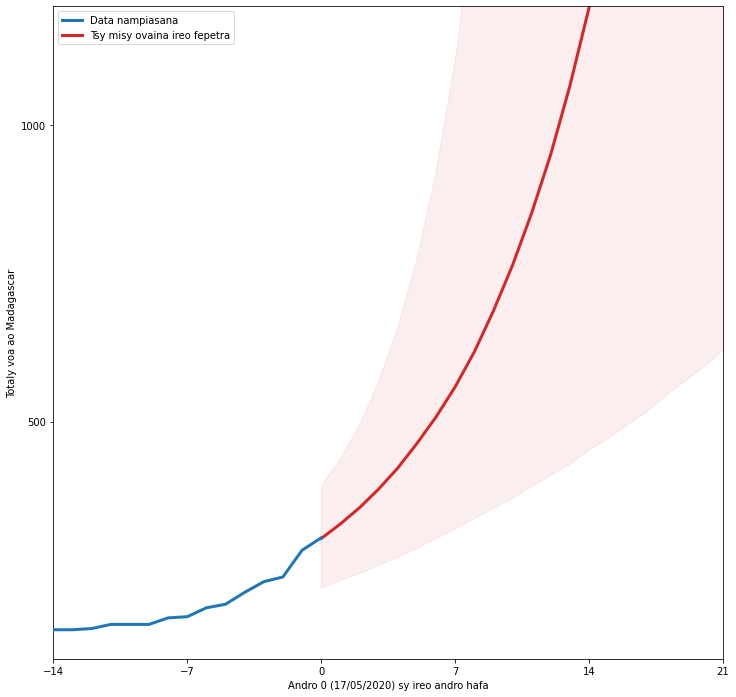

In [13]:
cases_obs_to_plot = cases_obs
cases_obs_to_plot_future = cases_obs

casfut1 = np.cumsum(trace['new_cases_no_change'], axis=1) + \
        np.sum(trace.new_cases_past, axis=1)[:, None] + cases_obs[0]
casesfut = casfut1.T


fig, ax = plt.subplots(figsize=[12, 12])

time = np.arange(-len(cases_obs_to_plot)+1, 1)
ax.plot(time, cases_obs_to_plot, label="Data nampiasana", linewidth=3, color='tab:blue', 
                zorder=5)
     
time = np.arange(0, len(cases_obs_to_plot_future))

time = np.arange(0, num_days_to_predict)

median = np.median(casesfut, axis=-1)
percentiles = (np.percentile(casesfut, q=2.5, axis=-1), np.percentile(casesfut, q=97.5, axis=-1),)
ax.plot(time, median, color = "tab:red", linewidth=3, label="Tsy misy ovaina ireo fepetra")
ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color="tab:red")

ax.set_xlim(-14, 21)
ax.set_ylim(100, 1200)
ax.set_yscale("linear")
ax.set(xlabel = "Andro 0 (17/05/2020) sy ireo andro hafa", ylabel= "Totaly voa ao Madagascar")
# ax.locator_params(axis='y', nbins=4)
ax.legend(loc="upper left")
ax.set_xticks([-14, -7, 0, 7, 14, 21])
ax.locator_params(nbins=4, axis="y")
#func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
#ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))


plt.savefig(path_to_save + "lambda1tanatoa.png", dpi=300)
plt.show()

In [14]:
cases_obs[0]

132.0